In [1]:
import os
from scipy.ndimage import gaussian_filter
import segyio
import numpy as np
import matplotlib.pyplot as plt


def smooth_velocity_field_file(input_filename, output_filename, sigma, show=False):
    """Smooths a velocity field using a Gaussian filter.

    Parameters
    ----------
    input_filename : string
        The name of the input file.
    output_filename : string
        The name of the output file.
    sigma : float
        The standard deviation of the Gaussian filter.
    show : boolean, optional
        Should the plot image appear on screen

    Returns
    -------
    None

    """
    f, filetype = os.path.splitext(input_filename)

    if filetype == ".segy":
        with segyio.open(input_filename, ignore_geometry=True) as f:
            nz, nx = len(f.samples), len(f.trace)
            vp = np.zeros(shape=(nz, nx))
            for index, trace in enumerate(f.trace):
                vp[:, index] = trace
    else:
        raise ValueError("Not yet implemented!")

    vp_smooth = gaussian_filter(vp, sigma)
    ni, nj = np.shape(vp)

    for i in range(ni):
        for j in range(nj):
            if vp[i, j] < 1.51 and i < 400:
                vp_smooth[i, j] = vp[i, j]

    spec = segyio.spec()
    spec.sorting = 2  # not sure what this means
    spec.format = 1  # not sure what this means
    spec.samples = range(vp_smooth.shape[0])
    spec.ilines = range(vp_smooth.shape[1])
    spec.xlines = range(vp_smooth.shape[0])

    assert np.sum(np.isnan(vp_smooth[:])) == 0

    with segyio.create(output_filename, spec) as f:
        for tr, il in enumerate(spec.ilines):
            f.trace[tr] = vp_smooth[:, tr]

    if show is True:
        with segyio.open(output_filename, ignore_geometry=True) as f:
            nz, nx = len(f.samples), len(f.trace)
            show_vp = np.zeros(shape=(nz, nx))
            for index, trace in enumerate(f.trace):
                show_vp[:, index] = trace

        fig, ax = plt.subplots()
        plt.pcolormesh(show_vp, shading="auto")
        plt.title("Guess model")
        plt.colorbar(label="P-wave velocity (km/s)")
        plt.xlabel("x-direction (m)")
        plt.ylabel("z-direction (m)")
        ax.axis("equal")
        plt.show()

    return None

In [4]:
import h5py

def list_hdf5_datasets(hdf5_filename):
    with h5py.File(hdf5_filename, 'r') as hdf5_file:
        def print_attrs(name, obj):
            print(name)
        hdf5_file.visititems(print_attrs)

hdf5_filename = '/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5'
list_hdf5_datasets(hdf5_filename)


velocity_model


In [9]:
import h5py
import segyio
import numpy as np

def hdf5_to_segy(hdf5_filename, segy_filename):
    # Read the .hdf5 file
    with h5py.File(hdf5_filename, 'r') as hdf5_file:
        # Ensure the correct dataset name is used
        velocity_data = hdf5_file['velocity_model'][:]  # Make sure the dataset name is correct
    
    # Get dimensions of the data
    nz, nx = velocity_data.shape

    # Create .segy file specification
    spec = segyio.spec()
    spec.sorting = segyio.TraceSortingFormat.INLINE_SORTING
    spec.format = 5  # IEEE floating-point format
    spec.samples = list(range(nz))
    spec.ilines = list(range(nx))
    spec.xlines = [0]  # Single line since it's 2D data

    # Write to the .segy file
    with segyio.create(segy_filename, spec) as segy_file:
        segy_file.text[0] = segyio.tools.wrap('', 3200)  # Optional: set text header
        segy_file.bin[segyio.BinField.Traces] = nx
        for i in range(nx):
            segy_file.trace[i] = velocity_data[:, i]

    print(f"Conversion complete: {hdf5_filename} -> {segy_filename}")

# Example usage
hdf5_filename = '/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5'
segy_filename = '/Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/marmousi_exact.segy'
hdf5_to_segy(hdf5_filename, segy_filename)



/Users/yw11823/ACSE/irp/firedrake/lib/python3.11/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)


Conversion complete: /Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/velocity_models/marmousi_exact.hdf5 -> /Users/yw11823/ACSE/irp/spyro/FWI_2D_DATA/marmousi_exact.segy


/Users/yw11823/ACSE/irp/firedrake/lib/python3.11/site-packages/segyio/utils.py:18: RuntimeWarning: Implicit conversion to contiguous array
  warnings.warn(msg, RuntimeWarning)
/Users/yw11823/ACSE/irp/firedrake/lib/python3.11/site-packages/segyio/utils.py:23: RuntimeWarning: Implicit conversion from float64 to float32 (narrowing)
  warnings.warn(msg.format(x.dtype, dtype), RuntimeWarning)


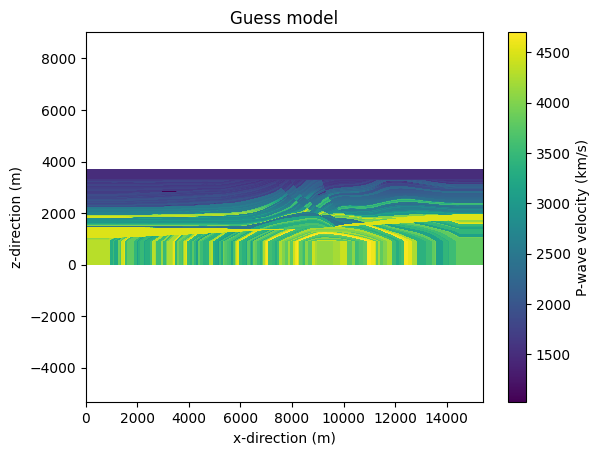

In [10]:
output_filename = "vp_guess4.segy"
sigma = 1.0
smooth_velocity_field_file(segy_filename, output_filename, sigma, show=True)
